# PatternMind Project

* **1. Introduction**
    - Description of project goals, dataset, and models here.

* **2. Data Preparation**
    * 2.1 Dataset Extraction & Loading
    * 2.2 Exploratory Data Analysis (EDA)
    * 2.3 Train/Test Split & Augmentation

* **3. Model Development**
    * 3.1 CNN, ANN, and Logistic Regression Models
    * 3.2 Hyperparameter Tuning (Cross-Validation)
    * 3.3 Final Training of Best Models

* **4. Evaluation**
    * 4.1 Test Performance Metrics
    * 4.2 Training Curves & Confusion Metrics

* **5. Clustering Analysis**
    * 5.1 Feature Extraction from CNN
    * 5.2 PCA + K-Means (Elbow & Silhouette)
    * 5.3 Cluster Interpretation
    * 5.4 Building Categories Through Clustering
    * 5.5 Semantic Relationships Analysis

# 1. Introduction

PatternMind is a dataset that contains folders split by item (or object) and contains images about that specific item. In this research our goal is not focused only on classification, but also uncovering patterns and relationships among the images in terms of the semantic relationsihps

# 2. Data Preparation


## 2.1 Imports and Setup
This cell mounts the Google Drive and imports the libraries we use for data manipulation, visualization and machine learning.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

Mounted at /content/drive


## 2.2 Dataset Extraction
This code sets up basic parameters for image handling such as image size and how many samples per class will be targeted later. It then locates the dataset zip file in Google Drive and extracts it into the working directory. The extraction step lets you access the folder named patternmind_dataset which should contain the images sorted by class. These setup choices help make later processing easier.

In [2]:
image_size=28
number_pixel=image_size*image_size*3
#Later in the code we calculated that 184 is double the median
valid_ext = (".png", ".jpg", ".jpeg", ".bmp") #???
np.random.seed(14062005)

zip_file_path = '/content/drive/MyDrive/patternmind_dataset.zip'
with zipfile.ZipFile(zip_file_path, "r") as zip_file:
    zip_file.extractall()
dataset = "patternmind_dataset"

## 2.3 Exploratory Data Analysis
This block of our code looks inside the dataset folder and identifies which subfolders represent classes. It counts how many images belong to each class and then prints out statistics including the number of classes, minimum and maximum class sizes, and the median size. After that it builds a smaller sample of classes so the bar chart is easier to read. This sample includes the largest classes, the smallest classes and a random selection of others. Finally it plots a bar chart showing how many images are in each of these classes. The goal is to understand whether the dataset has balanced or uneven class sizes.

Output analysis:

*   We found that the dataset was unbalanced since some folders had around 700 images while others around 100.


Number of classes: 233
Class range: [72, 761]
Median images per class: 92


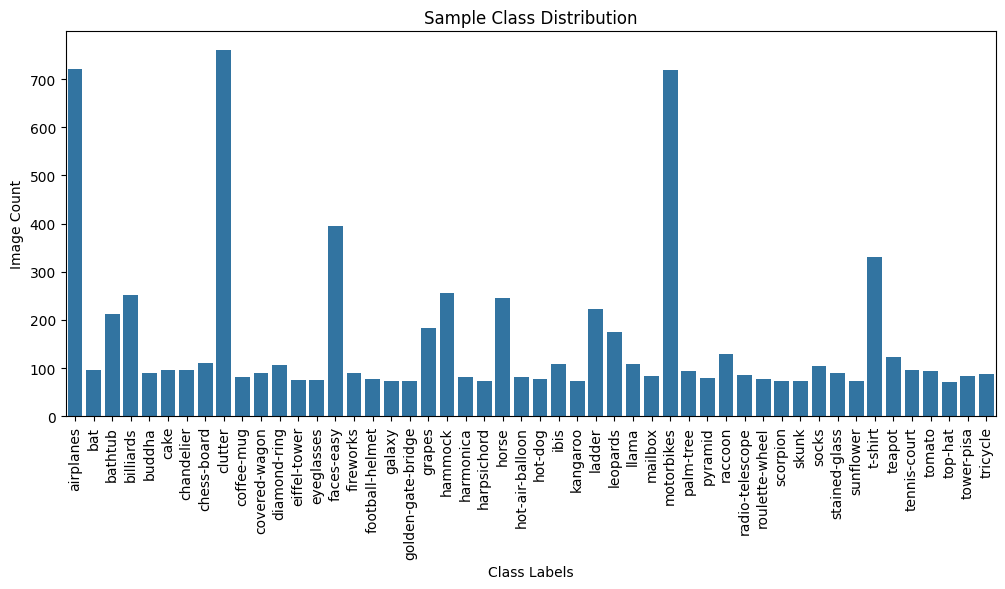

In [3]:
labels=[]
for item in os.listdir(dataset):
    path=os.path.join(dataset, item)
    if os.path.isdir(path):
        labels.append(item)

labels =sorted(labels)
num_classes =len(labels)
print(f"Number of classes: {num_classes}")

label_counter={}
for label in labels:
    folder=os.path.join(dataset, label)
    count=0
    for image in os.listdir(folder):
        if image.lower().endswith(valid_ext):
            count+=1
    label_counter[label]=count

max_images=max(label_counter.values())
min_images=min(label_counter.values())
print(f"Class range: [{min_images}, {max_images}]")

values=sorted(label_counter.values())
median=values[len(values)//2]
print(f"Median images per class: {median}")

label_counter_copy=label_counter.copy()
smaller_graph={}

for i in range(10):
    clas=max(label_counter_copy, key=label_counter_copy.get)
    smaller_graph[clas]=label_counter_copy.pop(clas)
for i in range(10):
    clas=min(label_counter_copy, key=label_counter_copy.get)
    smaller_graph[clas]=label_counter_copy.pop(clas)

keys=list(label_counter_copy.keys())
for i in np.random.choice(keys, 30, replace=False):
    smaller_graph[str(i)]=label_counter_copy[i]

smaller_graph=dict(sorted(smaller_graph.items()))

plt.figure(figsize=(12, 5))
sns.barplot(x=list(smaller_graph.keys()), y=list(smaller_graph.values()))
plt.xticks(rotation=90)
plt.title("Sample Class Distribution")
plt.xlabel("Class Labels")
plt.ylabel("Image Count")
plt.show()

## 2.4 Load Full Dataset
This block of code loads all images from the dataset folder using a TensorFlow function that automatically assigns labels based on folder names. It stores the images and their labels into NumPy arrays so they are easier to inspect and use later. The images are then normalized to a range between 0 and 1. Finally it prints the shapes of the image and label arrays as to confirm that everything loaded correctly. Temporary lists and unused objects are deleted to free memory.

In [4]:
whole_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset,
    seed=14062005,
    label_mode="int",
    image_size=(image_size, image_size),
    shuffle=False)

X_all_list = []
y_all_list = []
for images, labels_batch in whole_dataset:
    X_all_list.append(images.numpy())
    y_all_list.append(labels_batch.numpy())
X_all=np.concatenate(X_all_list, axis=0)
y_all=np.concatenate(y_all_list, axis=0)
X_all=X_all.astype('float32')/255

print(f"Image shape: {X_all.shape}")
print(f"Labels shape: {y_all.shape}")

del X_all_list, y_all_list, whole_dataset
gc.collect()

Found 25557 files belonging to 233 classes.
Image shape: (25557, 28, 28, 3)
Labels shape: (25557,)


13325

## 2.5 Train Test Split and Balancing

This code creates training and testing sets that keep every class at a consistent size. It first shuffles images inside each class then assigns a fixed number of samples to the test set. The remaining samples become part of the training set. If a class does not have enough images for the target training size the code uses image augmentation to generate new samples with slight visual changes so the training data remains balanced. Scaling classes to the same size helps reduce bias since every class contributes equally to model learning.

After preparing the data, the code block converts labels to categorical format which is required for neural networks to predict class probabilities. It also reshapes images into flat arrays which is useful for models that expect one vector. The printed summary shows how many samples ended up in the training and testing sets.

In [5]:
test_size=37
train_size_target=147
datagen=ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')

X_train_list=[]
y_train_list=[]
X_test_list=[]
y_test_list=[]

for c_index in range(num_classes):
    class_indices=(y_all==c_index)
    class_images=X_all[class_indices]
    number_images=class_images.shape[0]
    #Randomly shuffle images
    shuffled=np.random.permutation(number_images)
    class_images_shuffled=class_images[shuffled]

    #take 37 images for testing if the class has the right size
    if number_images>=test_size:
        test_images=class_images_shuffled[:test_size]
        train_images_original=class_images_shuffled[test_size:]
        n_test=test_size
        n_train_original=len(train_images_original)

        for img in test_images:
            X_test_list.append(img)
            y_test_list.append(c_index)
        for img in train_images_original:
            X_train_list.append(img)
            y_train_list.append(c_index)
        #Generate the necessary extra images
        n_augmented_needed=train_size_target-n_train_original
        if n_augmented_needed>0:
            generated=0
            for batch in datagen.flow(train_images_original, batch_size=1, shuffle=True):
                X_train_list.append(batch[0])
                y_train_list.append(c_index)
                generated+=1
                if generated>=n_augmented_needed:
                    break
        elif n_augmented_needed<0:
            n_to_remove=-n_augmented_needed
            X_train_list=X_train_list[:-n_to_remove]
            y_train_list=y_train_list[:-n_to_remove]
    else:
        n_test=number_images*0.2
        n_train_original=number_images-n_test
        test_images=class_images_shuffled[:n_test]
        train_images_original=class_images_shuffled[n_test:]

        for img in test_images:
            X_test_list.append(img)
            y_test_list.append(c_index)
        for img in train_images_original:
            X_train_list.append(img)
            y_train_list.append(c_index)

        n_augmented_needed=train_size_target-n_train_original
        if n_augmented_needed>0:
            generated=0
            for batch in datagen.flow(train_images_original, batch_size=1, shuffle=True):
                X_train_list.append(batch[0])
                y_train_list.append(c_index)
                generated+=1
                if generated>=n_augmented_needed:
                    break


X_train = np.array(X_train_list, dtype='float32')
y_train_int = np.array(y_train_list, dtype='int32')
X_test = np.array(X_test_list, dtype='float32')
y_test_int = np.array(y_test_list, dtype='int32')

print("TRAINING SET:")
print(f"Total samples: {len(X_train)}")
print(f"Shape: {X_train.shape}")
print("TEST SET:")
print(f"Total samples: {len(X_test)}")
print(f"Shape: {X_test.shape}")

y_train_categorical = to_categorical(y_train_int, num_classes)
y_test_categorical = to_categorical(y_test_int, num_classes)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

del X_all, y_all, X_train_list, y_train_list, X_test_list, y_test_list
gc.collect()

TRAINING SET:
Total samples: 34251
Shape: (34251, 28, 28, 3)
TEST SET:
Total samples: 8621
Shape: (8621, 28, 28, 3)


0

# 3. Model Development

## 3.1 CNN, ANN, and Logistic Regression Models
This code cell lays down the workflow for the optimization of our models. We separated a validation set from the training data, utilizing proportional sampling to ensure consistent class balance across both sets. Indeed, the output confirms that we have 27400 images for training and 6851 images for validation. This validation set is used to evaluate iterations without affecting our final test results.

We then defined dictionaries containing the hyperparameter specifications for the CNN, ANN, and Logistic Regression. We experimented with different hyperparameters like learning rates, layers, and dropout values.


In [6]:
X_train_tune, X_val, y_train_tune, y_val = train_test_split(
    X_train, y_train_categorical,
    test_size=0.2,
    random_state=14062005,
    stratify=y_train_int
)


cnn_configs = [
    {'filter_1':32, 'filter_2':64, 'dropout_rate':0.25, 'dense_units':128, 'learning_rate':0.001, 'batch_size':16, 'max_epochs':5},
    {'filter_1': 64, 'filter_2': 128, 'dropout_rate': 0.5, 'dense_units': 256, 'learning_rate': 0.0001, 'batch_size': 32, 'max_epochs': 5},
    {'filter_1': 64, 'filter_2': 128, 'dropout_rate': 0.5, 'dense_units': 512, 'learning_rate': 0.0001, 'batch_size': 16, 'max_epochs': 5},
    {'filter_1': 32, 'filter_2': 64, 'dropout_rate': 0.2, 'dense_units': 256, 'learning_rate': 0.001, 'batch_size': 32, 'max_epochs': 5},]
ann_configs = [
    {'hidden_1': 256, 'hidden_2': 128, 'dropout': 0.3, 'learning_rate': 0.001, 'max_epochs':5},
    {'hidden_1': 512, 'hidden_2': 256, 'dropout': 0.5, 'learning_rate': 0.0001, 'max_epochs': 5},
    {'hidden_1': 512, 'hidden_2': 256, 'dropout': 0.4, 'learning_rate': 0.0005, 'max_epochs': 5},]
lr_configs = [
    {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'},
    {'C': 1.0, 'max_iter': 200, 'solver': 'lbfgs'},
    {'C': 10.0, 'max_iter': 200, 'solver': 'lbfgs'}]

def create_cnn_model(config):
    model=Sequential([
        Conv2D(config['filter_1'], (3, 3), activation='relu',
               input_shape=(image_size, image_size, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(config['filter_2'], (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(config['dropout_rate']),
        Flatten(),
        Dense(config['dense_units'], activation='relu'),
        Dropout(config['dropout_rate']),
        Dense(num_classes, activation='softmax')])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

def create_ann_model(config):
    model=Sequential([
        Dense(config['hidden_1'], activation='relu', input_shape=(number_pixel,)),
        Dropout(config['dropout']),
        Dense(config['hidden_2'], activation='relu'),
        Dropout(config['dropout']),
        Dense(64, activation='relu'),
        Dropout(config['dropout']),
        Dense(num_classes, activation='softmax')])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

def create_logistic_regression(config):
    model=LogisticRegression(
        C=config['C'],
        max_iter=config['max_iter'],
        solver=config['solver'],
        random_state=14062005,
        n_jobs=-1,
        verbose=0)
    return model

## 3.2 Hyperparameter Tuning (Cross-Validation)
 To ensure our results aren't skewed by a specific data arrangement, we implemented a K-Fold Cross Validation loop and divided our training data into three distinct folds.

For every configuration, the model trains three separate times, rotating which fold is used as the validation test. This guarantees that our accuracy scores are robust and not biased by random luck. The code iterates through every hyperparameter combination we defined beforhand to identify the best one for each model type.It outputs a table and bar chart thus allowing us to visualize the optimal configurations.

Output analysis:

* Performance Comparison: The CNN is the clearly the best model, achieving 18.92% accuracy. This beats the Logistic Regression's 9.81% and the ANN's 1.16%. The ANN's low score implies it struggled to converge and was likely just guessing.

* Learning Rate: For the CNN, the higher learning rate of 0.001 was necessary. The lower 0.0001 rate was too slow to learn meaningful features given our constraint of only 5 epochs.

* Regularization: The stronger regularization in Logistic Regression (low C) reduced overfitting and produced the highest accuracy among its configurations, implying that a simpler model structure was actually more appropriate for this task.

CNN CROSSVALIDATION
Testing 4 configurations with 3-fold CV
configuration 1/4: {'filter_1': 32, 'filter_2': 64, 'dropout_rate': 0.25, 'dense_units': 128, 'learning_rate': 0.001, 'batch_size': 16, 'max_epochs': 5}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 1: 0.1617 (stopped at epoch 5)
  Fold 2: 0.1736 (stopped at epoch 5)
  Fold 3: 0.1675 (stopped at epoch 5)
Mean CV accuracy: 0.16758635143438974
configuration 2/4: {'filter_1': 64, 'filter_2': 128, 'dropout_rate': 0.5, 'dense_units': 256, 'learning_rate': 0.0001, 'batch_size': 32, 'max_epochs': 5}
  Fold 1: 0.0886 (stopped at epoch 5)
  Fold 2: 0.0834 (stopped at epoch 5)
  Fold 3: 0.0923 (stopped at epoch 5)
Mean CV accuracy: 0.08808502058188121
configuration 3/4: {'filter_1': 64, 'filter_2': 128, 'dropout_rate': 0.5, 'dense_units': 512, 'learning_rate': 0.0001, 'batch_size': 16, 'max_epochs': 5}
  Fold 1: 0.1237 (stopped at epoch 5)
  Fold 2: 0.1298 (stopped at epoch 5)
  Fold 3: 0.1317 (stopped at epoch 5)
Mean CV accuracy: 0.1284050072232882
configuration 4/4: {'filter_1': 32, 'filter_2': 64, 'dropout_rate': 0.2, 'dense_units': 256, 'learning_rate': 0.001, 'batch_size': 32, 'max_epochs': 5}
  Fold 1: 0.2167 (stopped at epoch 5)
  Fold 2: 0.2163 (stopped at epoch 5)
  Fold 3:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 1: 0.0145 (stopped at epoch 5)
  Fold 2: 0.0103 (stopped at epoch 5)
  Fold 3: 0.0130 (stopped at epoch 5)
Mean CV accuracy: 0.012612770621975264
configuration 2/3: {'hidden_1': 512, 'hidden_2': 256, 'dropout': 0.5, 'learning_rate': 0.0001, 'max_epochs': 5}
  Fold 1: 0.0119 (stopped at epoch 5)
  Fold 2: 0.0115 (stopped at epoch 5)
  Fold 3: 0.0058 (stopped at epoch 2)
Mean CV accuracy: 0.009722343956430754
configuration 3/3: {'hidden_1': 512, 'hidden_2': 256, 'dropout': 0.4, 'learning_rate': 0.0005, 'max_epochs': 5}
  Fold 1: 0.0129 (stopped at epoch 5)
  Fold 2: 0.0122 (stopped at epoch 5)
  Fold 3: 0.0137 (stopped at epoch 5)
Mean CV accuracy: 0.012904732798536619
Best: config 3 with 0.0129
LOGISTIC REGRESSION CROSSVALIDATION
configuration 1/3: {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
Fold 1: 0.1004
Fold 2: 0.0976
Fold 3: 0.0997
Mean CV Accuracy: 0.0992
configuration 2/3: {'C': 1.0, 'max_iter': 200, 'solver': 'lbfgs'}
Fold 1: 0.0739
Fold 2: 0.0759
Fold 3: 0.0726
Mean CV

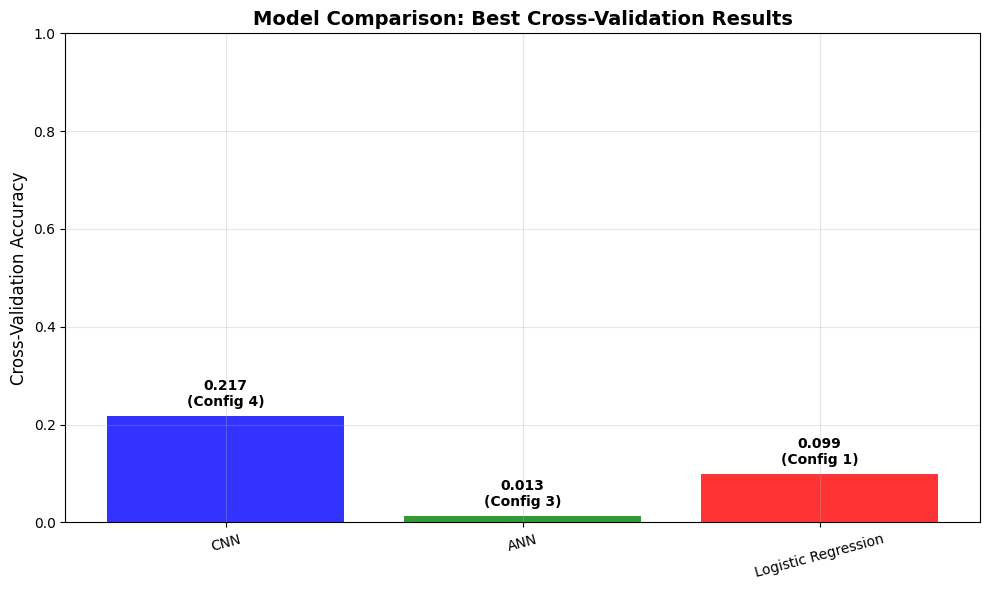

In [7]:
def cross_validate_model(model_fn, configs, X_data, y_data, model_name, needs_flatten=False):
    kfold=KFold(n_splits=3, shuffle=True, random_state=14062005)
    results=[]
    print(f"{model_name} CROSSVALIDATION")
    print(f"Testing {len(configs)} configurations with 3-fold CV")


    #configurations looping
    for configuration_number, configuration_setting in enumerate(configs):
        fold_scores=[]
        print(f"configuration {configuration_number+1}/{len(configs)}: {configuration_setting}")
        for fold, (train_conf, val_conf) in enumerate(kfold.split(X_data)):
            X_fold_train=X_data[train_conf]
            X_fold_val=X_data[val_conf]
            if needs_flatten:
                X_fold_train=X_fold_train.reshape(X_fold_train.shape[0], -1)
                X_fold_val=X_fold_val.reshape(X_fold_val.shape[0], -1)

            model=model_fn(configuration_setting)
            fitted_model=model.fit(
                X_fold_train, y_data[train_conf],
                batch_size=configuration_setting.get('batch_size', 16),
                epochs=5,
                validation_data=(X_fold_val, y_data[val_conf]),
                callbacks=[keras.callbacks.EarlyStopping(
                    monitor='val_loss', restore_best_weights=True
                )],
                verbose=0)
            fold_acc=max(fitted_model.history['val_accuracy'])
            fold_scores.append(fold_acc)
            print(f"  Fold {fold+1}: {fold_acc:.4f} (stopped at epoch {len(fitted_model.history['loss'])})")


        mean_acc=np.mean(fold_scores)
        results.append({'config':configuration_setting, 'mean_acc':mean_acc})
        print(f"Mean CV accuracy: {mean_acc}")

    best_conf=np.argmax([r['mean_acc'] for r in results])
    print(f"Best: config {best_conf+1} with {results[best_conf]['mean_acc']:.4f}")
    return results[best_conf]['config'], results

def cross_validate_lr(configs, X_data, y_data):
    kfold=KFold(n_splits=3, shuffle=True, random_state=14062005)
    results=[]
    X_flat=X_data.reshape(X_data.shape[0], -1)
    y_int=np.argmax(y_data, axis=1)
    print("LOGISTIC REGRESSION CROSSVALIDATION")

    #configurations looping
    for configuration_number, configuration_setting in enumerate(configs):
        fold_scores = []
        print(f"configuration {configuration_number+1}/{len(configs)}: {configuration_setting}")
        for fold, (train_conf, val_conf) in enumerate(kfold.split(X_flat)):
            X_fold_train=X_flat[train_conf]
            X_fold_val=X_flat[val_conf]
            y_fold_train=y_int[train_conf]
            y_fold_val=y_int[val_conf]

            model = create_logistic_regression(configuration_setting)
            model.fit(X_fold_train, y_fold_train)
            fold_acc = model.score(X_fold_val, y_fold_val)
            fold_scores.append(fold_acc)
            print(f"Fold {fold+1}: {fold_acc:.4f}")
        mean_acc = np.mean(fold_scores)
        results.append({'config': configuration_setting, 'mean_acc': mean_acc})
        print(f"Mean CV Accuracy: {mean_acc:.4f}")

    best_idx = np.argmax([r['mean_acc'] for r in results])
    print(f"Best: Config {best_idx+1} with {results[best_idx]['mean_acc']:.4f}")
    return results[best_idx]['config'], results


best_cnn_config, cnn_results=cross_validate_model(create_cnn_model, cnn_configs, X_train, y_train_categorical, "CNN")
best_ann_config, ann_results=cross_validate_model(create_ann_model, ann_configs, X_train, y_train_categorical, "ANN", needs_flatten=True)
best_lr_config, lr_results=cross_validate_lr(lr_configs, X_train, y_train_categorical)

print("SUMMARY:")
cv_summary = pd.DataFrame({
    'Model': ['CNN', 'ANN', 'Logistic Regression'],
    'Best CV Accuracy':[
        max([r['mean_acc'] for r in cnn_results]),
        max([r['mean_acc'] for r in ann_results]),
        max([r['mean_acc'] for r in lr_results]),],
    'Best Config #':[
        cnn_results.index(max(cnn_results, key=lambda x: x['mean_acc']))+1,
        ann_results.index(max(ann_results, key=lambda x: x['mean_acc']))+1,
        lr_results.index(max(lr_results, key=lambda x: x['mean_acc']))+1,]})

print(cv_summary.to_string(index=False))
plt.figure(figsize=(10, 6))
plt.bar(cv_summary['Model'], cv_summary['Best CV Accuracy'], color=['b', 'g', 'r'], alpha=0.8)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.title('Model Comparison: Best Cross-Validation Results', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3)
for i, (model, acc, cfg) in enumerate(zip(cv_summary['Model'],
                                           cv_summary['Best CV Accuracy'],
                                           cv_summary['Best Config #'])):
    plt.text(i, acc + 0.02, f'{acc:.3f}\n(Config {cfg})',
             ha='center', fontsize=10, fontweight='bold')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('cross_validation_comparison.png', dpi=150)
plt.show()

## 3.3 Final Training of Best Models
Now that we have the optimal hyperparameters selected, we now train the final versions of our models. We initialize the CNN, ANN, and Logistic Regression using these
settings and fit them to the full training set. While CNN gets the original image dimensions, ANN and Logistic Regression use the flattened arrays.

Output analysis:

 * The CNN is much more efficient. It achieved 26% training accuracy using only 1.4 million parameters, while the ANN reached 1.3% accuracy even though it is three times larger (4.1 million  parameters). This leads to the idea that convolutional layers are essential for image data. Both seem to have acclimated to new image as the accuracy/loss is similar between the training and validation set.


In [8]:
print("CNN with best configuration")
cnn_model = create_cnn_model(best_cnn_config)
history_cnn = cnn_model.fit(
    X_train_tune, y_train_tune,
    batch_size=best_cnn_config['batch_size'],
    epochs=best_cnn_config.get('max_epochs', 5),
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True)])
cnn_model.summary()

print("ANN with best configuration")
X_train_tune_flat = X_train_tune.reshape(X_train_tune.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
ann_model = create_ann_model(best_ann_config)
history_ann = ann_model.fit(
    X_train_tune_flat, y_train_tune,
    batch_size=16,
    epochs=best_ann_config.get('max_epochs', 5),
    validation_data=(X_val_flat, y_val),
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True)])
ann_model.summary()

print("Logistic regression with best configuration")
lr_model = create_logistic_regression(best_lr_config)
lr_model.fit(X_train_tune_flat, np.argmax(y_train_tune, axis=1))
print("Logistic Regression model summary:")
print(f"Number of iterations: {lr_model.n_iter_}")
print(f"Number of classes: {len(lr_model.classes_)}")

CNN with best configuration


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
857/857 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.0184 - loss: 5.3169 - val_accuracy: 0.0877 - val_loss: 4.6581
Epoch 2/5
857/857 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.1048 - loss: 4.4965 - val_accuracy: 0.1444 - val_loss: 4.2066
Epoch 3/5
857/857 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.1607 - loss: 4.0148 - val_accuracy: 0.1855 - val_loss: 3.9290
Epoch 4/5
857/857 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.2180 - loss: 3.6519 - val_accuracy: 0.2182 - val_loss: 3.7467
Epoch 5/5
857/857 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.2570 - loss: 3.3559 - val_accuracy: 0.2287 - val_loss: 3.6652


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 233)            │        59,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,467,389 (5.60 MB)

 Trainable params: 489,129 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 978,260 (3.73 MB)

ANN with best configuration


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.0040 - loss: 5.4953 - val_accuracy: 0.0039 - val_loss: 5.4511
Epoch 2/5
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.0048 - loss: 5.4521 - val_accuracy: 0.0067 - val_loss: 5.4410
Epoch 3/5
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.0058 - loss: 5.4438 - val_accuracy: 0.0077 - val_loss: 5.4180
Epoch 4/5
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.0068 - loss: 5.4253 - val_accuracy: 0.0104 - val_loss: 5.4032
Epoch 5/5
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.0083 - loss: 5.4117 - val_accuracy: 0.0114 - val_loss: 5.3908


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                │ (None, 512)            │     1,204,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 233)            │        15,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,102,973 (15.65 MB)

 Trainable params: 1,367,657 (5.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,735,316 (10.43 MB)

Logistic regression with best configuration
Logistic Regression model summary:
Number of iterations: [100]
Number of classes: 233


# 4. Evaluation

### 4.1 Test Performance Metrics

This code evaluates the three trained models: CNN, ANN, Logistic Regression model. First, we generate predictions for each model and then convert probability outputs into class labels so that all models can be compared in a consistent way. Moreover, we computed key classification metrics such as accuracy, precision, recall, and F1 score, which help show how well each model handles unseen data.

Output Analysis:

* CNN is the strongest model with about 19.6% accuracy, but its precision (0.1851) and F1 (0.1753) still show weak overall performance
* ANN performs very poorly with only 1.22% accuracy and an F1 of 0.0031, indicating almost no effective learning
* Logistic Regression reaches 9.74% accuracy and an F1 of 0.0848, better than ANN but still far below acceptable performance


In [9]:
y_pred_cnn_prob=cnn_model.predict(X_test, batch_size=32, verbose=0)
y_pred_cnn=np.argmax(y_pred_cnn_prob, axis=1)
y_pred_ann_prob=ann_model.predict(X_test_flat, batch_size=32, verbose=0)
y_pred_ann=np.argmax(y_pred_ann_prob, axis=1)
y_pred_lr=lr_model.predict(X_test_flat)

def print_metrics(name, y_true, y_pred):
    acc=accuracy_score(y_true, y_pred)
    prec=precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec=recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1=f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n{name}:")
    print(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    return acc

acc_cnn=print_metrics("CNN", y_test_int, y_pred_cnn)
acc_ann=print_metrics("ANN", y_test_int, y_pred_ann)
acc_lr=print_metrics("Logistic Regression", y_test_int, y_pred_lr)


CNN:
Accuracy:  0.1923 (19.23%)
Precision: 0.1990
Recall:    0.1923
F1-Score:  0.1732

ANN:
Accuracy:  0.0093 (0.93%)
Precision: 0.0029
Recall:    0.0093
F1-Score:  0.0024

Logistic Regression:
Accuracy:  0.0979 (9.79%)
Precision: 0.0808
Recall:    0.0979
F1-Score:  0.0852


### 4.2 Training Curves & Metrics Tables

This code produces 4 plots that show how the CNN and ANN models learned during training. The plots on the top row shows training accuracy and validation accuracy for the CNN and ANN, and the plots on the bottom row shows training loss and validation loss for each model.

There is no training curve for logistic regression in this visualization. The reason is that the neural networks are trained with Keras, which records accuracy and loss at every epoch and stores them in a history object.

Logistic regression is trained with the scikit learn library, which does not record a step by step history during optimization. It simply fits the model and returns the final result. However, logistic regression is evaluated only through performance metrics.

The second part of the code examines how each model performs on every individual class. For each class, the code counts how many samples were predicted correctly and how many were predicted incorrectly, then computes an accuracy value for that class. The output lists the five best classes and the five worst classes for the CNN, ANN, and logistic regression models.

Output Analysis:

* The CNN reaches about 19.6% accuracy and shows steady improvements in its learning curves, but the validation accuracy consistently is above the training accuracy, which is expected when augmentation is applied only to the training data or when the training images are simply harder than those in the validation split.
* The ANN remains extremely low at around 1.2% accuracy, and its validation accuracy also exceeds its training accuracy, reinforcing that the model is not learning effectively and that the training data is likely more challenging due to augmentation or more likely the ANN i.
* Logistic Regression reaches about 9.7 percent accuracy and still performs better than the ANN even though both use raw pixel inputs. This happens because Logistic Regression applies a single linear decision boundary across all pixel values at once, which can sometimes pick up simple global patterns like overall brightness or silhouette shape. The ANN, on the other hand, must learn these patterns through multiple layers and weights, and without convolution it struggles to detect spatial structure in images. As a result the ANN becomes overwhelmed by the high dimensional input, while Logistic Regression remains simpler and more stable, allowing it to perform slightly better on this type of data.
* Across all three models, the tables show a consistent pattern: a few classes achieve very high accuracy (up to ~97%), while many remain at 0%, suggesting that certain classes are inherently much easier and likely have patterns easier to recognise.

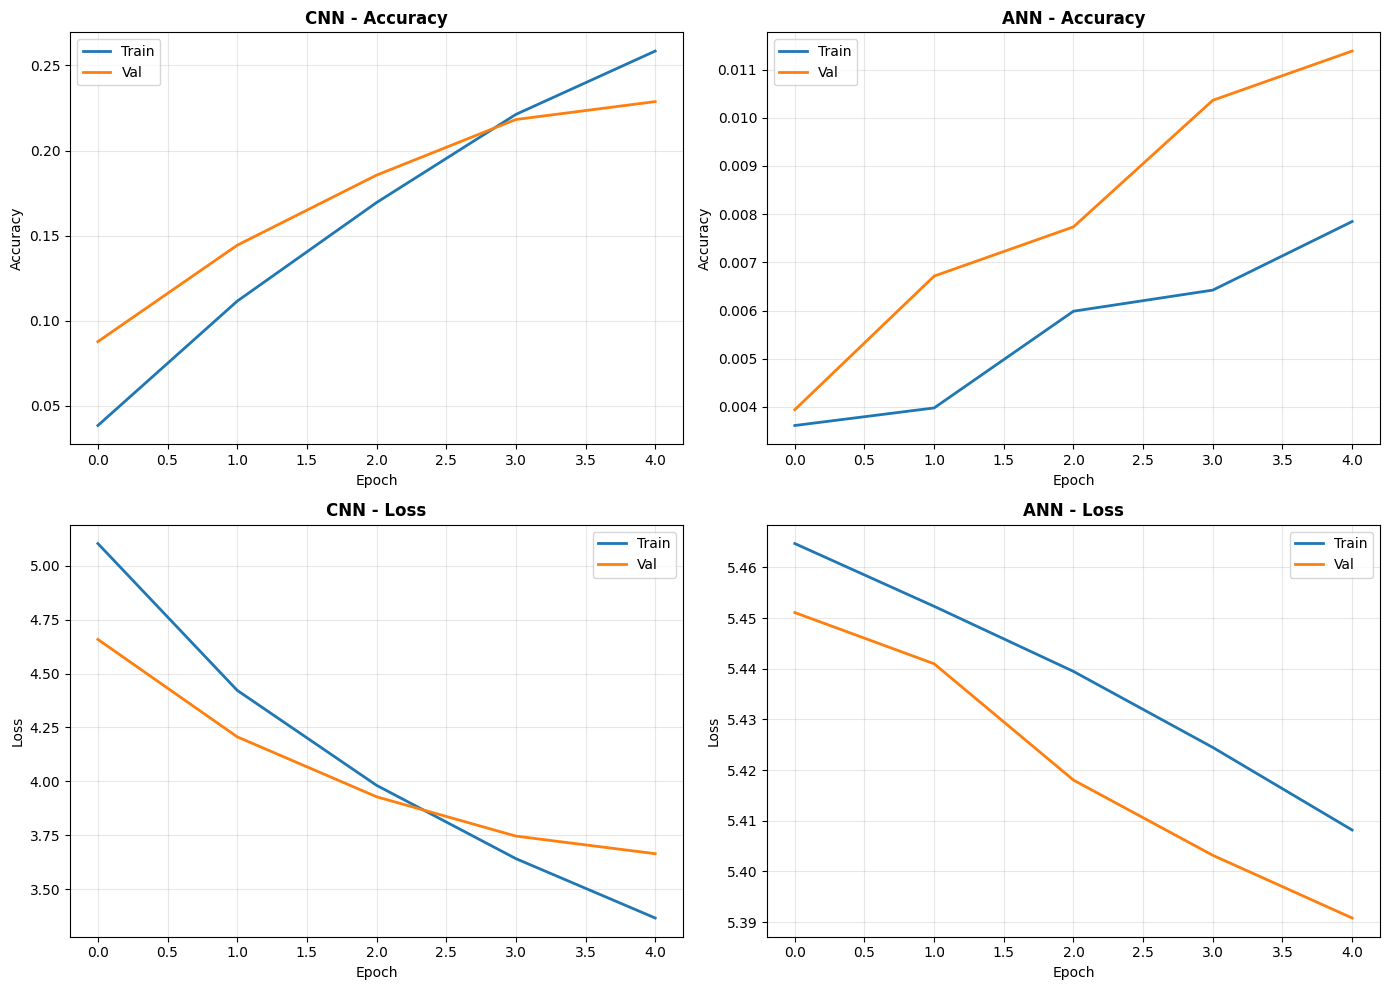

CNN: TOP 5 BEST PERFORMING CLASSES:
Rank   Class                          Total    Correct    Wrong    Accuracy  
1      car-side                       37       37         0        100.00%
2      faces-easy                     37       32         5        86.49%
3      motorbikes                     37       31         6        83.78%
4      self-propelled-lawn-mower      37       27         10       72.97%
5      airplanes                      37       26         11       70.27%
CNN TOP 5 WORST PERFORMING CLASSES:
Rank   Class                          Total    Correct    Wrong    Accuracy  
1      yo-yo                          37       0          37       0.00%
2      tuning-fork                    37       0          37       0.00%
3      traffic-light                  37       0          37       0.00%
4      smokestack                     37       0          37       0.00%
5      spider                         37       0          37       0.00%
ANN: TOP 5 BEST PERFORMING CLASSES:


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(history_cnn.history['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history_cnn.history['val_accuracy'], label='Val', linewidth=2)
axes[0, 0].set_title('CNN - Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[1, 0].plot(history_cnn.history['loss'], label='Train', linewidth=2)
axes[1, 0].plot(history_cnn.history['val_loss'], label='Val', linewidth=2)
axes[1, 0].set_title('CNN - Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_ann.history['accuracy'], label='Train', linewidth=2)
axes[0, 1].plot(history_ann.history['val_accuracy'], label='Val', linewidth=2)
axes[0, 1].set_title('ANN - Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 1].plot(history_ann.history['loss'], label='Train', linewidth=2)
axes[1, 1].plot(history_ann.history['val_loss'], label='Val', linewidth=2)
axes[1, 1].set_title('ANN - Loss', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

def analyze_per_class_performance(y_true, y_pred, labels, model_name):
    class_performance=[]
    for c_index in range(len(labels)):
        number_images=(y_true==c_index)
        n_samples=np.sum(number_images)
        if n_samples==0:
            continue
        class_predictions=y_pred[number_images]
        n_correct=np.sum(class_predictions==c_index)
        n_wrong=n_samples-n_correct
        accuracy=(n_correct/n_samples)*100
        class_performance.append({
            'Model': model_name,
            'Class': labels[c_index],
            'Total': n_samples,
            'Correct': n_correct,
            'Wrong': n_wrong,
            'Accuracy': accuracy})
    df=pd.DataFrame(class_performance)
    df_sorted=df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
    best_5=df_sorted.head(5)
    worst_5=df_sorted.tail(5).iloc[::-1]

    print(f"{model_name}: TOP 5 BEST PERFORMING CLASSES:")
    print(f"{'Rank':<6} {'Class':<30} {'Total':<8} {'Correct':<10} {'Wrong':<8} {'Accuracy':<10}")
    for idx, row in best_5.iterrows():
        rank=idx+1
        print(f"{rank:<6} {row['Class']:<30} {row['Total']:<8} {row['Correct']:<10} {row['Wrong']:<8} {row['Accuracy']:.2f}%")
    print(f"{model_name} TOP 5 WORST PERFORMING CLASSES:")
    print(f"{'Rank':<6} {'Class':<30} {'Total':<8} {'Correct':<10} {'Wrong':<8} {'Accuracy':<10}")
    for idx, row in worst_5.iterrows():
        rank=len(df)-idx
        print(f"{rank:<6} {row['Class']:<30} {row['Total']:<8} {row['Correct']:<10} {row['Wrong']:<8} {row['Accuracy']:.2f}%")
    return df

cnn_performance = analyze_per_class_performance(y_test_int, y_pred_cnn, labels, "CNN")
ann_performance = analyze_per_class_performance(y_test_int, y_pred_ann, labels, "ANN")
lr_performance = analyze_per_class_performance(y_test_int, y_pred_lr, labels, "LOGISTIC REGRESSION")

# 5. Clustering Analysis

### 5.1 Feature Extraction from CNN

This code prepares the data for clustering by using the trained CNN as a feature extractor. This is because feature vectors capture higher level visual patterns learned during classification. The printed shape and feature dimension tell you how many samples and how many features per sample will be used for clustering.

Since these feature vectors can still be high dimensional, the code then applies PCA to reduce them to two principal components for visualization. PCA keeps as much variance as possible in a lower dimensional space, which is helpful for plotting and sometimes for speeding up later clustering steps. The reported percentages for the first and second principal components show how much of the original information is preserved in this two dimensional projection.

Output Analysis:

* PC1 at 6.6% and PC2 at 5.8% show that the first two PCA components capture very little of the CNN feature variation, meaning most information lies in many other dimensions.
* Well separated features often have 20 to 40 percent explained variance in the first two components, so values around 6 percent suggest the 2D PCA plot will not show strong clusters.
* This does not make clustering invalid, but it means the 2D visualization is only a rough view and does not reflect most of the structure the network learned.

In [11]:
feature_extractor=tf.keras.Sequential(cnn_model.layers[:-1])
feature_extractor.trainable=False

X_balanced_norm=X_train
features=feature_extractor.predict(X_balanced_norm, batch_size=32, verbose=0)
n_samples=features.shape[0]
y_balanced=y_train_int

pca=PCA(n_components=2, random_state=14062005)
features_2d=pca.fit_transform(features)

pc1_var=pca.explained_variance_ratio_[0] * 100
pc2_var=pca.explained_variance_ratio_[1] * 100
print(f"PC1 explains: {pc1_var:.1f}% of variance")
print(f"PC2 explains: {pc2_var:.1f}% of variance")

max_points_for_scatter=5000
if n_samples>max_points_for_scatter:
    rng = np.random.default_rng(14062005)
    scatter_indices = rng.choice(n_samples, size=max_points_for_scatter, replace=False)
else:
    scatter_indices = np.arange(n_samples)

PC1 explains: 5.7% of variance
PC2 explains: 5.5% of variance


### 5.2 PCA + K-Means (Elbow & Silhouette)

This section uses two common methods, the elbow method and the silhouette method, to estimate how many clusters are appropriate for the feature vectors extracted from the CNN. The elbow method measures how the within cluster inertia decreases as the number of clusters increases, and it looks for a point where improvements slow down. The silhouette method evaluates how well samples fit within their assigned clusters compared to other clusters. These two perspectives help avoid choosing a number of clusters that is either too small or unnecessarily large. The meaning of this section depends on the shapes of the generated plots and the silhouette scores printed by the code.

After estimating a reasonable range for the number of clusters, the code visualizes the K Means results for three particular values of k. It overlays the cluster assignments on the two dimensional PCA projection to give a more intuitive sense of how separated the clusters appear. These visualizations help confirm whether the chosen values of k create meaningful structure in the data or whether clusters overlap significantly.

Analyze the outputs:
* Examine the elbow and silhouette plots to identify which values of k produce stable or high quality clusters.
* Look at the PCA scatter plots to see whether the clusters appear visually separated and whether the chosen k values match the patterns suggested by the earlier methods.

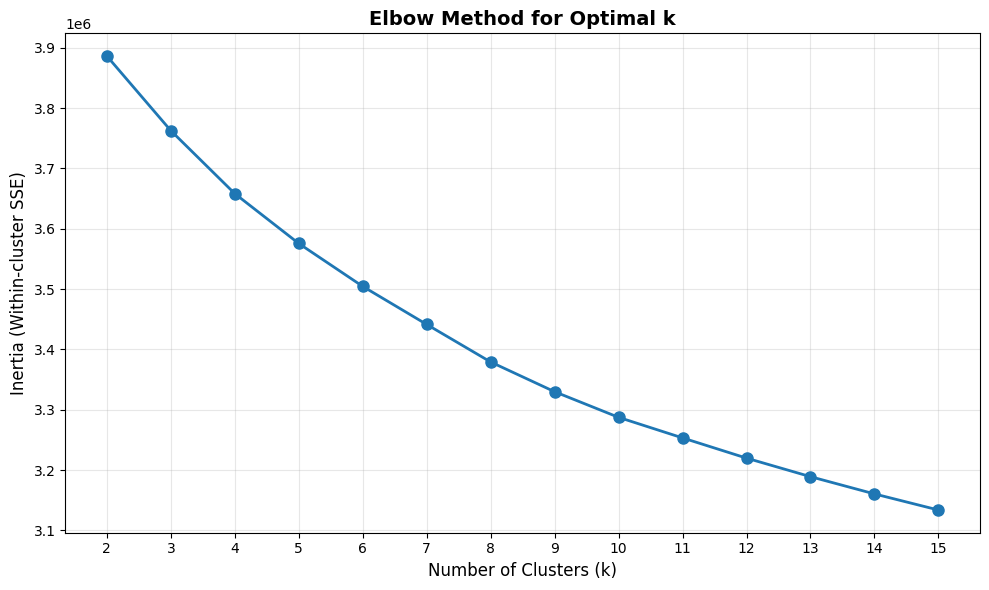

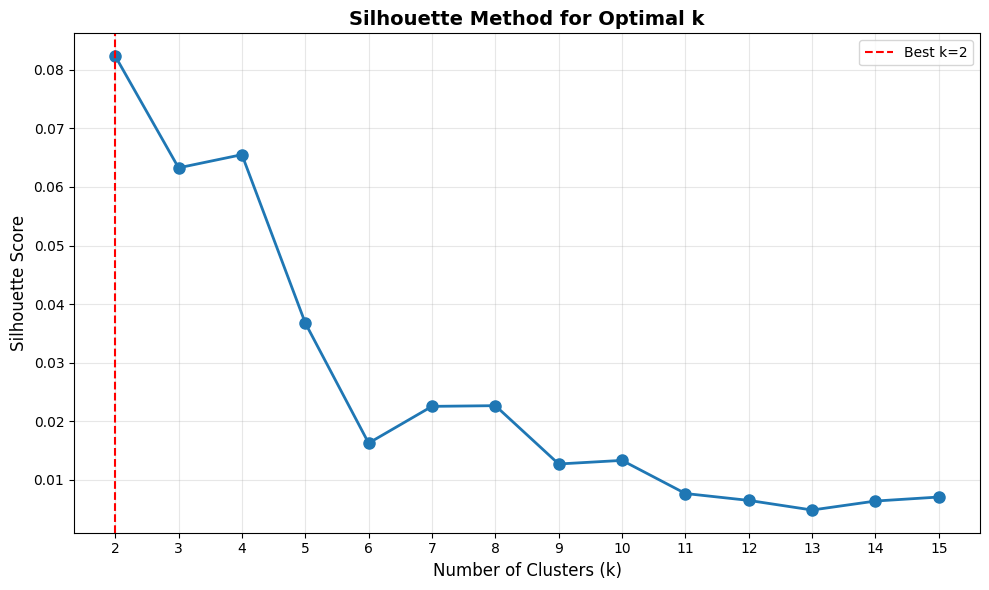

Best k by silhouette: 2
Cluster visualization


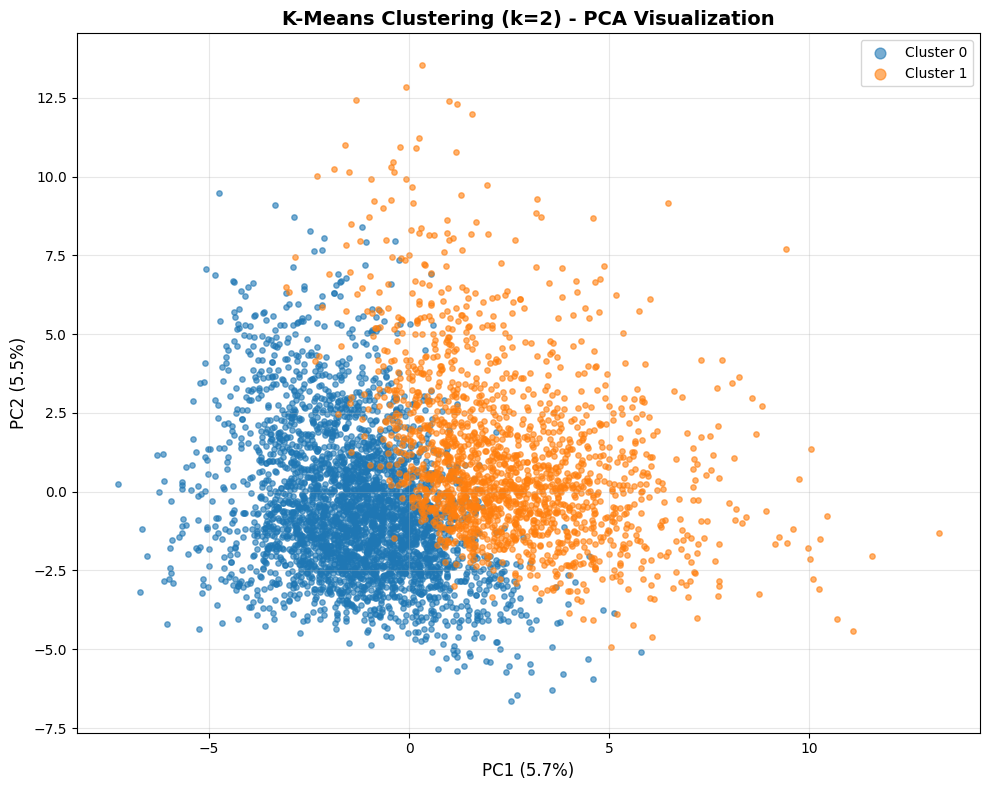

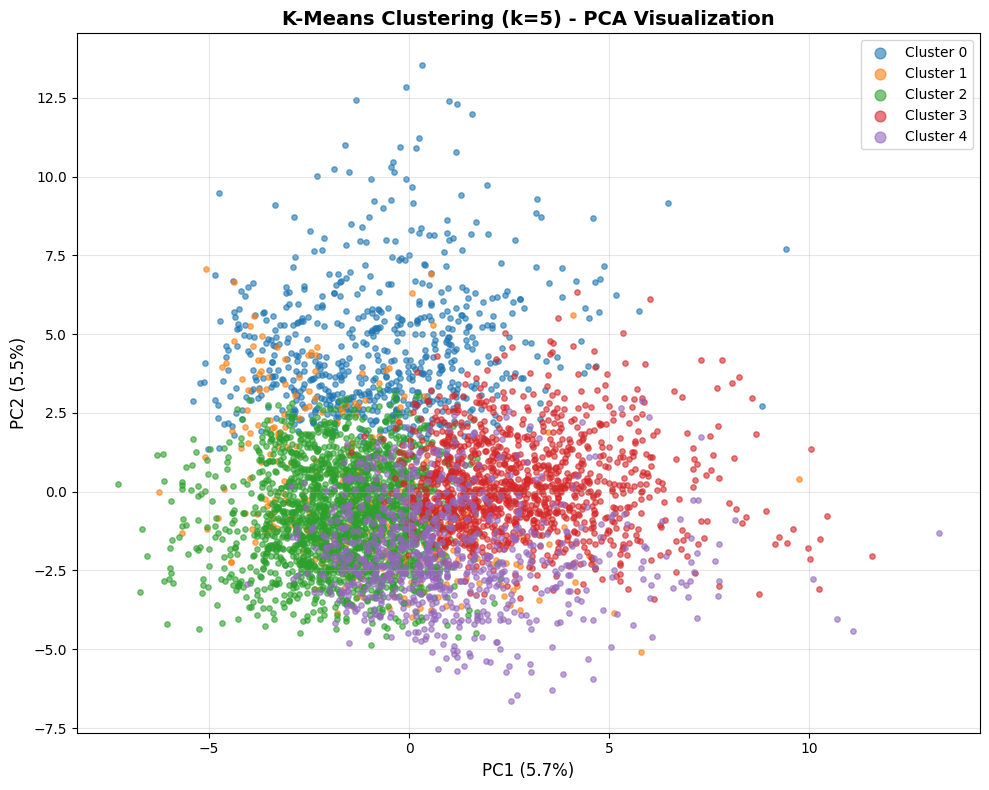

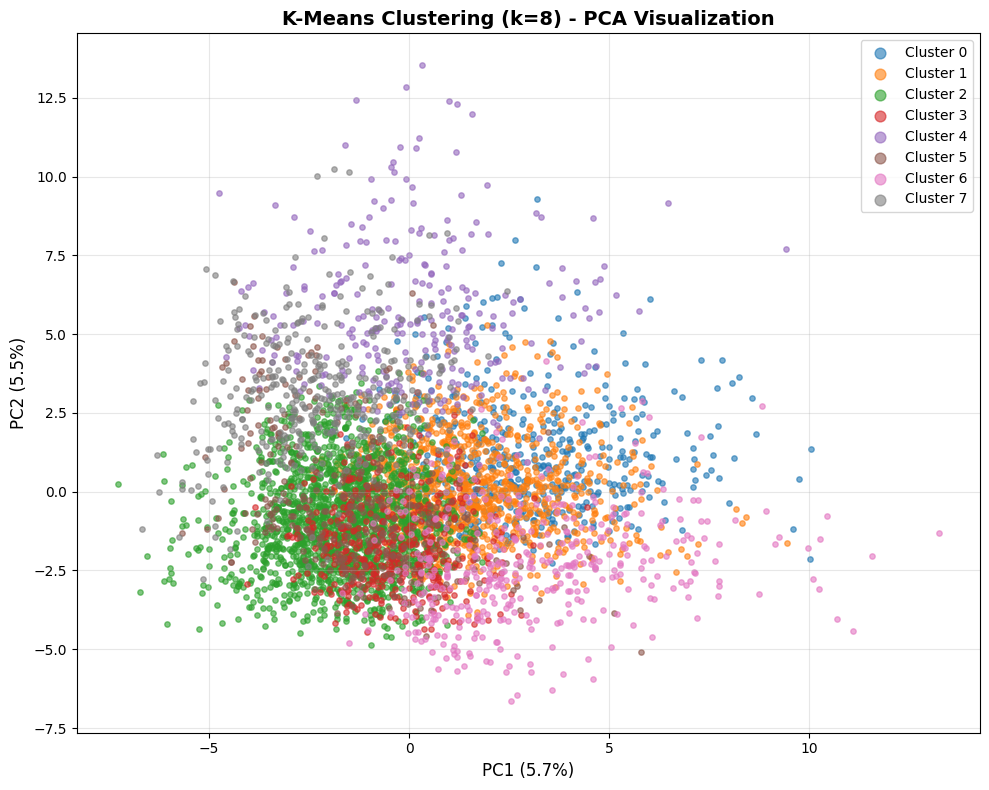

In [12]:
min_k = 2
max_k = 15
K_range = list(range(min_k, max_k + 1))

inertias = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(features)
    inertias.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
plt.xticks(K_range)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Within-cluster SSE)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('kmeans_elbow_method.png', dpi=150)
plt.show()

silhouette_scores_list = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(features)
    sample_size = min(2000, n_samples)
    score = silhouette_score(features, labels_k, sample_size=sample_size, random_state=42)
    silhouette_scores_list.append(score)

best_k_index = int(np.argmax(silhouette_scores_list))
best_k_silhouette = int(K_range[best_k_index])

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores_list, marker='o', linewidth=2, markersize=8)
plt.xticks(K_range)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Method for Optimal k', fontsize=14, fontweight='bold')
plt.axvline(best_k_silhouette, color='red', linestyle='--', label=f'Best k={best_k_silhouette}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('kmeans_silhouette_method.png', dpi=150)
plt.show()

print(f"Best k by silhouette: {best_k_silhouette}")
print("Cluster visualization")

k_values_to_visualize=[2, 5, 8]
kmeans_labels_dict={}
for k in k_values_to_visualize:
    km=KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k=km.fit_predict(features)
    kmeans_labels_dict[k]=labels_k

    labels_sub=labels_k[scatter_indices]
    x_sub=features_2d[scatter_indices, 0]
    y_sub=features_2d[scatter_indices, 1]

    plt.figure(figsize=(10, 8))
    for cluster_id in range(k):
        mask=(labels_sub==cluster_id)
        plt.scatter(x_sub[mask], y_sub[mask], s=15, alpha=0.6, label=f'Cluster {cluster_id}')

    plt.xlabel(f'PC1 ({pc1_var:.1f}%)', fontsize=12)
    plt.ylabel(f'PC2 ({pc2_var:.1f}%)', fontsize=12)
    plt.title(f'K-Means Clustering (k={k}) - PCA Visualization', fontsize=14, fontweight='bold')
    plt.legend(markerscale=2, fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    fname=f'kmeans_pca_k{k}.png'
    plt.savefig(fname, dpi=150)
    plt.show()

### 5.3 Cluster Interpretation

This code finalizes the clustering analysis and then prints a concise summary of the whole project. First, it focuses on a specific number of clusters, k equal to 5, and examines what each cluster actually represents in terms of semantic content. For each cluster, it looks at which original classes appear inside it and how large their contribution is, expressed as a percentage of that class that falls into the cluster. By assigning each class to the cluster where it is most represented, the code builds a list of classes for every cluster and prints the top classes per cluster. This helps interpret the clusters not just as numbers, but as groups of semantically related image classes.

After the clustering analysis, the code prints a final project summary. It reports basic dataset statistics, the test performance of the three models CNN, ANN, and Logistic Regression, and explicitly states which model performed best on the test set. It also reminds the reader of the chosen clustering setting by giving the optimal k found by the silhouette method and the k used for the final semantic analysis. How you interpret this section depends on the printed cluster compositions and the numerical performance values.

Analyze the outputs:
	•	Look at the semantic cluster assignments to see whether the classes grouped into each cluster share meaningful visual or semantic similarities.
	•	Review the final performance summary to compare the three models and check whether the identified best model and the chosen clustering configuration match your expectations from earlier steps.

In [13]:
final_k = 5
cluster_labels_final=kmeans_labels_dict[final_k]

label_totals=np.bincount(y_balanced, minlength=num_classes)
cluster_data={}
for cluster_id in range(final_k):
    cluster_name=f"Cluster {cluster_id}"
    cluster_mask=(cluster_labels_final == cluster_id)
    classes_in_cluster=y_balanced[cluster_mask]
    entries=[]
    for c_index in range(num_classes):
        total_for_label=label_totals[c_index]
        count=np.sum(classes_in_cluster==c_index)
        if count==0:
            continue
        pct_of_label=(count/total_for_label)*100.0
        entries.append((labels[c_index], pct_of_label))

    cluster_data[cluster_name]=entries

best_cluster_for_class={}
for cluster_name, entries in cluster_data.items():
    for name, pct in entries:
        if name not in best_cluster_for_class or pct > best_cluster_for_class[name][1]:
            best_cluster_for_class[name]=(cluster_name, pct)

semantic_cluster_data={f"Cluster {i}": [] for i in range(final_k)}
for name, (best_cluster, pct) in best_cluster_for_class.items():
    semantic_cluster_data[best_cluster].append((name, pct))

for cluster_name, entries in semantic_cluster_data.items():
    print(f"\n{cluster_name} ({len(entries)} classes):")
    entries_sorted=sorted(entries, key=lambda x: x[1], reverse=True)
    for name, pct in entries_sorted[:10]:
        print(f"{name}: {pct:.1f}%")
    if len(entries)>10:
        print(f"... and {len(entries)-10} more classes")

print("PROJECT SUMMARY")

print(f"\nDataset:")
print(f"  Total classes: {num_classes}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")

print(f"\nModel Performance (Test Set):")
print(f"  CNN:                 {acc_cnn*100:.2f}%")
print(f"  ANN:                 {acc_ann*100:.2f}%")
print(f"  Logistic Regression: {acc_lr*100:.2f}%")

print("Best Model: CNN")

print(f"Final analysis performed with k={final_k}")


Cluster 0 (20 classes):
tomato: 93.2%
sunflower: 90.5%
hamburger: 78.9%
spaghetti: 77.6%
watermelon: 72.8%
telephone-box: 70.1%
hibiscus: 65.3%
boxing-glove: 61.9%
cereal-box: 61.9%
superman: 44.9%
... and 10 more classes

Cluster 1 (7 classes):
saturn: 93.2%
galaxy: 85.7%
comet: 74.1%
mars: 72.8%
fireworks: 61.2%
faces-easy: 44.9%
brain: 37.4%

Cluster 2 (116 classes):
fern: 91.2%
leopards: 88.4%
chimp: 87.8%
raccoon: 87.8%
elk: 87.1%
porcupine: 86.4%
grapes: 84.4%
toad: 84.4%
elephant: 84.4%
bear: 83.7%
... and 106 more classes

Cluster 3 (66 classes):
breadmaker: 86.4%
binoculars: 84.4%
toaster: 81.6%
head-phones: 77.6%
calculator: 75.5%
motorbikes: 74.1%
cd: 73.5%
paper-shredder: 73.5%
pci-card: 68.7%
tennis-shoes: 68.7%
... and 56 more classes

Cluster 4 (24 classes):
car-side: 91.8%
golden-gate-bridge: 88.4%
airplanes: 83.7%
ketch: 76.2%
killer-whale: 75.5%
helicopter: 74.8%
radio-telescope: 72.1%
windmill: 71.4%
fighter-jet: 67.3%
rainbow: 66.7%
... and 14 more classes
PROJECT 

### 5.4 Building Categories Through Clustering

This cell computes a semantic cluster view for a chosen number of clusters using KMeans on the feature space. It either reuses existing cluster labels for the selected value of k or fits a new KMeans model, then counts how many samples from each original class fall into each cluster relative to the total samples of that class. In other words, it asks for each class where most of its samples ended up and turns that into percentages.

Next, each class is assigned only to the single cluster where its percentage is highest, building a cleaned up mapping from clusters to their most strongly associated classes. The code then prints a readable list that shows for every cluster which classes it mainly contains, sorted by percentage. How you interpret the quality of the clustering will depend on looking at this printed semantic cluster view and the percentages shown for each class.

Output Analysis:

* Cluster 0 captures a very large mix of classes with many percentages above fifty percent, which suggests that much of the feature space collapses into a broad catch all cluster. This usually means the embedding space does not separate many visual themes strongly enough for the chosen value of k.
* Clusters 1 and 2 show clearer thematic coherence, for example foods or instruments in Cluster 1 and many electronic or mechanical objects in Cluster 2. This indicates that some categories do form meaningful groupings even though others blend together.
* Cluster 3 groups astronomy images and a few visually bright or high contrast classes, while Cluster 4 captures a small set of objects with strong color or shape signatures. These concentrated clusters show that when the features do separate well they create tight groups.
* The extremely dominant size of Cluster 0 suggests that k equals five may be too small for this dataset. When one cluster absorbs most classes it usually implies the model needs more clusters to capture finer structure.
* This does not mean the clustering is wrong. It means the current grouping offers only a rough view of the semantic structure and many important relationships between classes likely appear only when k is increased or other clustering methods are explored.

In [14]:
final_k = 5
km_final = KMeans(n_clusters=final_k, random_state=14062005, n_init=10)
cluster_labels_final = km_final.fit_predict(features)
label_totals = np.bincount(y_balanced, minlength=num_classes)

cluster_data = {}
for cluster_id in range(final_k):
    cluster_name = f"Cluster {cluster_id}"
    cluster_filter = (cluster_labels_final == cluster_id)
    classes_in_cluster = y_balanced[cluster_filter]
    entries = []
    if cluster_filter.sum() == 0:
        cluster_data[cluster_name] = entries
        continue
    for class_idx in range(num_classes):
        total_for_label = label_totals[class_idx]
        if total_for_label == 0:
            continue
        count = np.sum(classes_in_cluster == class_idx)
        if count == 0:
            continue

        pct_of_label = (count / total_for_label) * 100.0
        class_name = labels[class_idx]
        entries.append((class_name, pct_of_label))

    cluster_data[cluster_name] = entries

best_cluster_for_class = {}
for cluster_name, entries in cluster_data.items():
    for cls_name, pct in entries:
        if cls_name not in best_cluster_for_class or pct > best_cluster_for_class[cls_name][1]:
            best_cluster_for_class[cls_name] = (cluster_name, pct)

semantic_cluster_data = {f"Cluster {i}": [] for i in range(final_k)}
for cls_name, (best_cluster, pct) in best_cluster_for_class.items():
    semantic_cluster_data[best_cluster].append((cls_name, pct))

for cluster_name, entries in semantic_cluster_data.items():
    print(f"\n{cluster_name}")
    entries_sorted = sorted(entries, key=lambda x: x[1], reverse=True)
    for name, pct in entries_sorted:
        print(f"  {name}: {pct:.1f}%")
    print()


Cluster 0
  fern: 90.5%
  leopards: 88.4%
  chimp: 87.8%
  raccoon: 87.8%
  elk: 87.1%
  porcupine: 85.7%
  elephant: 85.0%
  toad: 85.0%
  grapes: 84.4%
  bear: 83.7%
  zebra: 82.3%
  snake: 81.6%
  owl: 79.6%
  kangaroo: 77.6%
  llama: 77.6%
  mussels: 77.6%
  hummingbird: 75.5%
  iguana: 75.5%
  spider: 75.5%
  waterfall: 75.5%
  iris: 74.1%
  birdbath: 73.5%
  dog: 73.5%
  greyhound: 73.5%
  horseshoe-crab: 72.8%
  grasshopper: 72.1%
  cannon: 71.4%
  horse: 71.4%
  penguin: 71.4%
  sextant: 70.7%
  trilobite: 70.7%
  camel: 70.1%
  goat: 70.1%
  people: 70.1%
  butterfly: 69.4%
  cactus: 69.4%
  bat: 68.7%
  praying-mantis: 68.7%
  snail: 68.0%
  harp: 66.7%
  ladder: 66.0%
  lathe: 65.3%
  mushroom: 64.6%
  ostrich: 64.6%
  bulldozer: 63.9%
  hammock: 63.9%
  school-bus: 63.9%
  tombstone: 63.9%
  duck: 63.3%
  centipede: 61.9%
  billiards: 61.2%
  segway: 61.2%
  stained-glass: 61.2%
  giraffe: 59.9%
  chandelier: 59.2%
  doorknob: 59.2%
  bonsai: 58.5%
  cormorant: 58.5%
  tou

### 5.5 Semantic Relationships Analysis

These charts help us understand how much each broad semantic theme contributes to a cluster. Earlier we manually inspected the class names inside each cluster and grouped them into larger themes such as animals and wildlife or personal tech and tools. We did this by reading the names and only checking images when a word was unclear. Once we had those themes, the bar charts let us see roughly how much of the cluster each theme represents.

We originally used this process to decide what macro theme label best describes each cluster. Now the code simply displays those decisions in a quantitative way so we can confirm that the chosen macro theme matches the actual distribution of content inside the cluster.

Output Analysis:

* In the animals and nature cluster the animals and wildlife theme dominates and clearly makes up the largest share of the cluster. This is the strongest and most obvious macro theme because the majority of the cluster is built from animal classes.
* In the food toys music cluster the food related theme is the largest but the cluster is more balanced across several themes. This reflects that the cluster mixes different types of everyday objects and playful items but still has a clear emphasis on food.
* In the personal tech cluster the themes related to tools appliances accessories and media devices take up most of the cluster. This is why we named it personal tech and tools because the majority of the content is built from objects in that category.
* In the astronomy and light cluster the astronomy and space theme stands out as the largest and the light related theme is the second biggest. This confirms that the cluster is mostly driven by visual brightness and astronomical imagery.
* In the bold red objects cluster the food and natural produce theme is the highest but the public red objects and symbolic items contribute as well. This matches the idea that this cluster tends to group items with strong red color or iconic appearance.


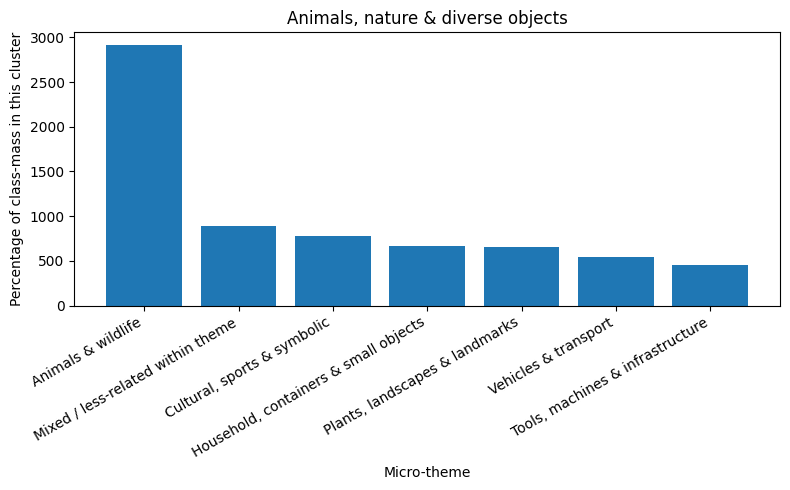

Semantic micro-theme bar chart saved as semantic_Cluster_0_microthemes.png

=== Animals, nature & diverse objects (Cluster 0) ===
- Animals & wildlife: leopards, zebra, ostrich, porcupine, elk, kangaroo, raccoon, giraffe, iguana, skunk, grasshopper, bear, toad, goose, llama, elephant, owl, snake, chimp, horseshoe-crab, goat, camel, horse, dog, cormorant, spider, snail, scorpion, ibis, praying-mantis, bat, hummingbird, mussels, butterfly, octopus, centipede, house-fly, triceratops, swan, cockroach, greyhound, starfish
- Plants, landscapes & landmarks: fern, palm-tree, cactus, bonsai, waterfall, skyscraper, smokestack, iris, grapes, mushroom
- Vehicles & transport: covered-wagon, bulldozer, fire-truck, touring-bike, mountain-bike, segway, snowmobile, wheelbarrow, car-tire, school-bus
- Tools, machines & infrastructure: lathe, microscope, sextant, gas-pump, traffic-light, tuning-fork, ladder, fire-hydrant, smokestack
- Household, containers & small objects: picnic-table, hammock, birdbath

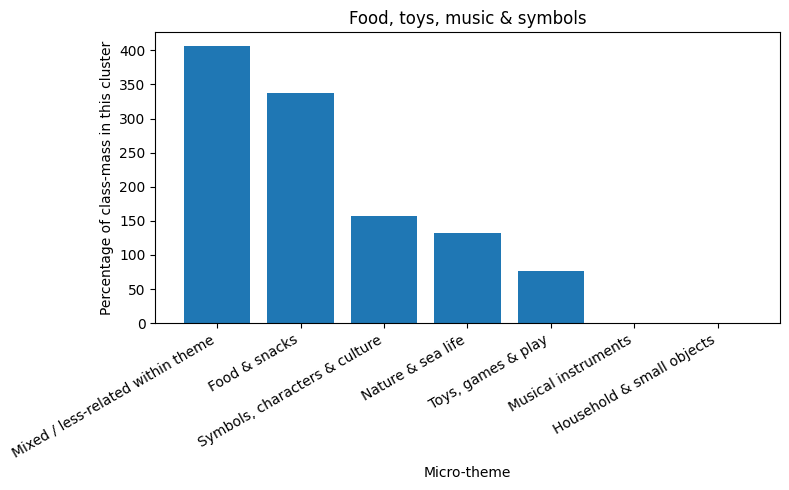

Semantic micro-theme bar chart saved as semantic_Cluster_1_microthemes.png

=== Food, toys, music & symbols (Cluster 1) ===
- Food & snacks: hamburger, spaghetti, fried-egg, hot-dog, cereal-box, drinking-straw
- Toys, games & play: teddy-bear, tennis-ball
- Nature & sea life: sunflower, goldfish
- Symbols, characters & culture: superman, cartman, coffin, hot-air-balloon
- Mixed / less-related within theme: boxing-glove, fire-extinguisher, hibiscus, telephone-box, tomato, watermelon


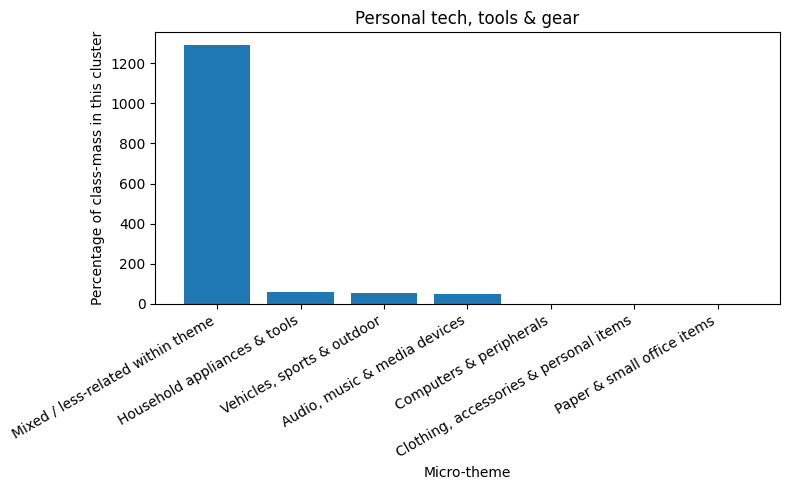

Semantic micro-theme bar chart saved as semantic_Cluster_2_microthemes.png

=== Personal tech, tools & gear (Cluster 2) ===
- Audio, music & media devices: vcr
- Household appliances & tools: self-propelled-lawn-mower
- Vehicles, sports & outdoor: treadmill
- Mixed / less-related within theme: airplanes, american-flag, blimp, car-side, dolphin-101, eiffel-tower, fighter-jet, golden-gate-bridge, helicopter, kayak, ketch, killer-whale, lightning, minaret, pyramid, radio-telescope, rainbow, teepee, tennis-court, tower-pisa, windmill


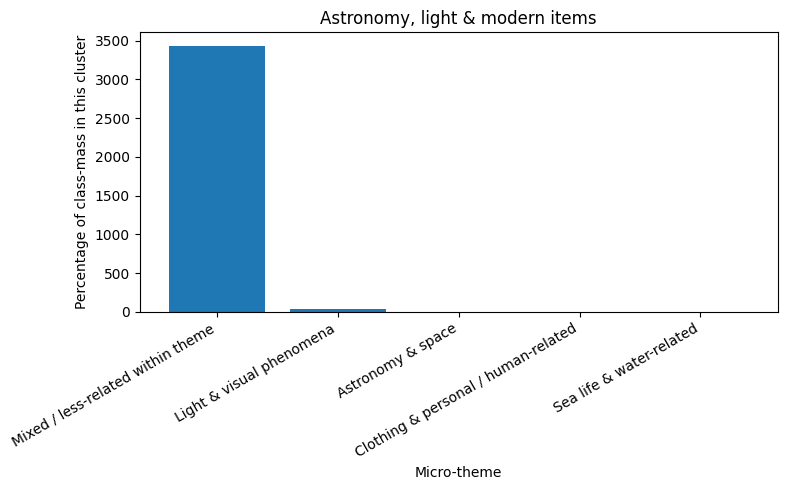

Semantic micro-theme bar chart saved as semantic_Cluster_3_microthemes.png

=== Astronomy, light & modern items (Cluster 3) ===
- Light & visual phenomena: lightbulb
- Mixed / less-related within theme: backpack, baseball-glove, binoculars, boom-box, bowling-ball, bowling-pin, breadmaker, calculator, cd, chopsticks, coffee-mug, coin, computer-keyboard, computer-mouse, cowboy-hat, desk-globe, diamond-ring, eyeglasses, flashlight, floppy-disk, football-helmet, frying-pan, grand-piano-101, guitar-pick, harmonica, head-phones, ipod, joy-stick, laptop, license-plate, mattress, megaphone, microwave, motorbikes, necktie, palm-pilot, paper-shredder, paperclip, pci-card, photocopier, playing-card, refrigerator, screwdriver, sheet-music, sneaker, soccer-ball, socks, spoon, stirrups, swiss-army-knife, syringe, t-shirt, tambourine, tennis-shoes, theodolite, toaster, top-hat, umbrella, video-projector, washing-machine, watch, welding-mask, yarmulke, yo-yo


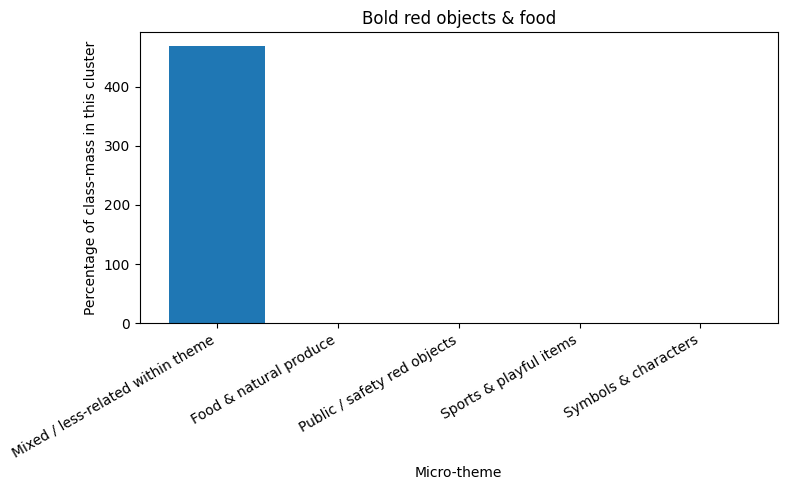

Semantic micro-theme bar chart saved as semantic_Cluster_4_microthemes.png

=== Bold red objects & food (Cluster 4) ===
- Mixed / less-related within theme: brain, comet, faces-easy, fireworks, galaxy, mars, saturn

 K-Means clustering & semantic micro-theme analysis complete.


In [15]:
semantic_names = {
    "Cluster 0": "Animals, nature & diverse objects",
    "Cluster 1": "Food, toys, music & symbols",
    "Cluster 2": "Personal tech, tools & gear",
    "Cluster 3": "Astronomy, light & modern items",
    "Cluster 4": "Bold red objects & food",}
micro_themes = {
     "Cluster 0": {
        "Animals & wildlife": [
            "leopards", "zebra", "ostrich", "porcupine", "elk", "kangaroo",
            "raccoon", "giraffe", "iguana", "skunk", "grasshopper", "bear",
            "toad", "goose", "llama", "elephant", "owl", "snake", "chimp",
            "horseshoe-crab", "goat", "camel", "horse", "dog", "cormorant",
            "spider", "snail", "scorpion", "ibis", "praying-mantis", "bat",
            "killer-whale", "hummingbird", "mussels", "butterfly", "octopus",
            "centipede", "dolphin-101", "house-fly", "triceratops", "swan",
            "cockroach", "greyhound", "starfish"],
        "Plants, landscapes & landmarks":[
            "fern", "palm-tree", "cactus", "bonsai", "waterfall",
            "golden-gate-bridge", "tower-pisa", "pyramid", "skyscraper",
            "windmill", "minaret", "eiffel-tower", "radio-telescope",
            "smokestack", "iris", "grapes", "mushroom", "rainbow"],
        "Vehicles & transport": [
            "covered-wagon", "bulldozer", "fire-truck", "touring-bike",
            "mountain-bike", "airplanes", "fighter-jet", "helicopter",
            "blimp", "segway", "snowmobile", "kayak", "ketch", "wheelbarrow",
            "car-side", "car-tire", "hot-air-balloon", "school-bus"],
        "Tools, machines & infrastructure": [
            "lathe", "theodolite", "microscope", "sextant", "photocopier",
            "gas-pump", "traffic-light", "tuning-fork", "ladder",
            "fire-hydrant", "radio-telescope", "smokestack"],
        "Household, containers & small objects": [
            "tennis-court", "picnic-table", "hammock", "birdbath", "hot-tub",
            "mailbox", "doorknob", "steering-wheel", "wine-bottle",
            "soda-can", "teapot", "coffee-mug", "spoon", "socks",
            "chopsticks", "mattress", "bathtub", "coin", "syringe",
            "tricycle", "chandelier"],
        "Cultural, sports & symbolic": [
            "cannon", "rifle", "ak47", "french-horn", "electric-guitar",
            "billiards", "golf-ball", "football-helmet", "stirrups",
            "menorah", "buddha", "jesus-christ", "tombstone", "people",
            "clutter", "minotaur", "stained-glass"],
    },
    "Cluster 1": {
        "Food & snacks": [
            "hamburger", "spaghetti", "fried-egg", "hot-dog",
            "cereal-box", "ice-cream-cone", "drinking-straw", "cake"],
        "Toys, games & play": [
            "teddy-bear", "roulette-wheel", "chess-board",
            "baseball-glove", "tennis-ball", "playing-card",
            "dice", "yo-yo", "bowling-pin"],
        "Musical instruments": [
            "mandolin", "harpsichord", "harp", "xylophone", "tambourine",
            "french-horn"],
        "Nature & sea life": [
            "sunflower", "goldfish", "conch", "starfish"],
        "Symbols, characters & culture": [
            "superman", "american-flag", "cartman", "stained-glass",
            "coffin", "desk-globe", "cowboy-hat", "hot-air-balloon",
            "school-bus", "buddha", "jesus-christ"],
        "Household & small objects": [
            "doorknob", "hourglass", "bathtub", "coin", "saddle", "sextant"],
    },
    "Cluster 2": {
        "Audio, music & media devices": [
            "head-phones", "boom-box", "video-projector",
            "harmonica", "grand-piano-101", "guitar-pick", "cd", "megaphone",
            "vcr"],
        "Computers & peripherals": [
            "pci-card", "calculator", "computer-keyboard",
            "computer-mouse", "laptop", "palm-pilot"],
        "Household appliances & tools": [
            "toaster", "washing-machine", "screwdriver",
            "swiss-army-knife", "flashlight", "frying-pan",
            "self-propelled-lawn-mower", "microwave", "breadmaker",
            "paper-shredder", "refrigerator"],
        "Clothing, accessories & personal items": [
            "tennis-shoes", "sneaker", "eyeglasses", "diamond-ring",
            "watch", "backpack", "umbrella", "top-hat", "t-shirt",
            "yarmulke", "necktie", "socks"],
        "Vehicles, sports & outdoor": [
            "motorbikes", "soccer-ball", "treadmill", "license-plate",
            "tennis-ball"],
        "Paper & small office items": [
            "sheet-music", "paperclip", "binoculars", "joy-stick",
            "floppy-disk"],
    },
    "Cluster 3": {
        "Astronomy & space": [
            "comet", "galaxy", "saturn", "mars"],
        "Light & visual phenomena": [
            "lightning", "fireworks", "lightbulb"],
        "Clothing & personal / human-related": [
            "faces-easy", "brain"],
        "Sea life & water-related": [
            "dolphin-101", "killer-whale"],
    },
    "Cluster 4": {
        "Food & natural produce": [
            "tomato", "watermelon", "hibiscus"],
        "Public / safety red objects": [
            "telephone-box", "fire-extinguisher"],
        "Sports & playful items": [
            "boxing-glove", "pez-dispenser"],
        "Symbols & characters": [
            "american-flag", "cartman"],
    },
}

for cluster_name, entries in semantic_cluster_data.items():
    if not entries:
        continue
    value_dict = {name: pct for name, pct in entries}
    mt_map = micro_themes.get(cluster_name, {})
    if not mt_map:
        continue
    micro_values = {}
    for mt_name, class_list in mt_map.items():
        total = 0.0
        for cls in class_list:
            total += value_dict.get(cls, 0.0)
        micro_values[mt_name] = total

    assigned_classes = {c for clist in mt_map.values() for c in clist}
    mixed_classes = [cls for cls, pct in entries if cls not in assigned_classes]

    mixed_total = 0.0
    mixed_label = "Mixed / less-related within theme"
    if mixed_classes:
        mixed_total = sum(value_dict.get(cls, 0.0) for cls in mixed_classes)
        if mixed_total > 0:
            micro_values[mixed_label] = mixed_total

    micro_items = sorted(micro_values.items(), key=lambda x: x[1], reverse=True)
    mt_labels = [name for name, val in micro_items]
    mt_values = [val for name, val in micro_items]


    plt.figure(figsize=(max(8, len(mt_labels) * 0.8), 5))
    x_pos = range(len(mt_labels))
    plt.bar(x_pos, mt_values)
    plt.xticks(x_pos, mt_labels, rotation=30, ha='right')
    plt.ylabel("Percentage of class-mass in this cluster")
    plt.xlabel("Micro-theme")
    title = semantic_names.get(cluster_name, cluster_name)
    plt.title(title)
    plt.tight_layout()
    fname = f"semantic_{cluster_name.replace(' ','_')}_microthemes.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    print(f"Semantic micro-theme bar chart saved as {fname}")
    print(f"\n=== {title} ({cluster_name}) ===")
    for mt_name, class_list in mt_map.items():
        present_classes = [c for c in class_list if c in value_dict]
        if not present_classes:
            continue
        classes_str = ", ".join(present_classes)
        print(f"- {mt_name}: {classes_str}")

    if mixed_classes:
        print(f"- {mixed_label}: {', '.join(mixed_classes)}")

print("\n K-Means clustering & semantic micro-theme analysis complete.")